# Introduction and EDA

<a id ='TOC'></a>
#### Table of Contents

1. [Introduction and Description of Data](#Introduction_Description_of_Data) <br/>
    1.1 [Data](#Data) <br/>
    1.2 [Data in Twitter API](#Data-in-Twitter-API) <br/>
    1.3 [Collection of Data](#Collection-of-Data) <br/>
    1.4 [Data Labelling: Using Botometer](#Labelling-Botometer) <br/>
    1.5 [Data Labelling: Manually](#Labelling-Manual) <br/>
    1.6 [Data Collection: Most Recent 200 Tweets per Each User](#Data-Collection-Recent) <br/>
    1.7 [Description of Raw Data (Tweets)](#Description-of-Raw-Data) <br/>  

2. [Exploratory Data Analysis](#Exploratory-Data-Analysis) <br/>
    2.1 [Data Wrangling & Cleansing](#Data-Wrangling-Cleansing) <br/>
    2.2 [Feature Engineering](#Feature-Engineering)<br/>
  > 2.2.1 [Feature Engineering - Tweet Features](#FE-Tweet-Features) <br/>
  > 2.2.2 [Feature Engineering - User Features](#FE-User-Features)<br/>
  > 2.2.3 [Feature Engineering - Finalize and Clean Up Data](#FE-Finalize-Clean)<br/>
  
   2.3 [Advanced Feature Engineering - NLP Features](#NLP-Features)<br/>
   2.4 [Important Features](#Important-Features) <br/>
   2.5 [Relations in Data](#Relations-in-Data) <br/>
   2.6 [Standardization](#Standardization) <br/>   

___

[Back to TOC](#TOC) <br/>
<a id ='Introduction'></a>
## 1- Introduction and Description of Data

The main objective of the project is explore twitter dataset using twitter API and try to create a learning algorithim that can differentiate between bot and human Twitter account.

In [0]:
#@title 
# Import Libraries, Global Options and Styles
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)
%matplotlib inline

#import libraries
import warnings
warnings.filterwarnings('ignore')

import tweepy
import random
random.seed(112358)

%matplotlib inline
import numpy as np
import scipy as sp
import json as json
import pandas as pd
import jsonpickle
import time


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from pandas.plotting import scatter_matrix
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

import scipy.sparse as ss
import os
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.utils import np_utils

import statsmodels.api as sm
from statsmodels.api import OLS

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import pandas as pd
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn.apionly as sns
sns.set(style="darkgrid")
sns.set_context("poster")

[Back to TOC](#TOC) <br/>
<a id ='Data'></a>
### 1.1 - Data <br/>

We started with three potential approaches to collect data for bot detection:

#### Approach 1: Collect Tweets then Label Bot / Real Users: 

> *Approach* - Collect Tweets via Twitter API, extract accounts, then use Botometer API to label bot / real-user <br/>
    *Pros* - flexible in collecting the specific data we are interested <br/>
    *Cons* - using Botometer to label accounts might result in a fitting of Botometer's algorithms



#### Approach 2: Collect Bot and Real Users Separately
>*Approach* - Manually select / verify bots account, use verified twitter profile accounts for the real user dataset, then use Twitter API to collect Tweets from the selected accounts <br/>
*Pros* - very accurate response (bot / real user) <br/>
*Cons* - time consuming and therefore small data size

#### Approach 3: Use Existing Annotated Dataset
>*Approach* - Use existing datasets that have already labelled the tweets as bot / real-user <br/>
*Pros* - convenient <br/>
*Cons* - less flexible in collecting tweets with specific topic; results highly rely on the labelling accuracy

After evaluating the three approaches, we decided to collect our own tweets and use Botometer to label the bot / real-user. We decided to use the following approach to collect and label our data:

> Step 1: Collection of Data : Collect over 6,000 tweets <br/>
> Step 2: Data Labelling: Use Botometer  <br/>
> Step 3: Data Labelling: Chose to Manual Verify 40 accouts (20 bots, 20 actual users) <br/>
> Step 4: Data Collection - Get 200 (max) Most Recent Tweets from Each 6,000+ Tweets Account



[Back to TOC](#TOC) <br/>
<a id ='Data-in-Twitter-API'></a>
### 1.2 - Data Source: Twitter API with Tweepy

We used Twitter API via Tweepy to collect all our data by searching for tweets that include certain keywords, and by retrieving most recent 200 tweets from speicified users. 

[Back to TOC](#TOC) <br/>
<a id ='Collection-of-Data'></a>
### 1.3 - Collection of Data : Collect over 6,000 Tweets using Keywords

We first collected some tweets that contains one of the following keywords that are likely to lead to controversial topics:  <br/>
>  1) Immigration <br/>
>  2) Brexit <br/>
>  3) bitcoin <br/>

We used keywords of more controversial topics as those are more likely to have non-obvious bots.

In [0]:
# http://www.tweepy.org/
import tweepy

# Replace the API_KEY and API_SECRET with your application's key and secret.
auth = tweepy.AppAuthHandler("apikey", "api secret")

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
 
if (not api):
    print ("Can't Authenticate")
    sys.exit(-1)

In [0]:
# The following code was adapted from sample code provided by TFs / Profs for this project

def collect_tweets(maxTs, requestCount, filename):
    searchQuery = 'Immgration OR Brexit OR bitcoin'  # this is what we're searching for
    maxTweets = maxTs # some arbitrary large number
    tweetsPerQry = 100  # this is the max the API permits
    fName = filename # we'll store the tweets in a text file.

    # If results from a specific ID onwards are reqd, set since_id to that ID.
    # else default to no lower limit, go as far back as API allows
    sinceId = None

    # If results only below a specific ID are, set max_id to that ID.
    # else default to no upper limit, start from the most recent tweet matching the search query.
    max_id = -1
    error_count = 0

    request_count = 0

    tweetCount = 0
    
    
    print("Downloading max {0} tweets".format(maxTweets))
    with open(fName, 'w') as f:
        while tweetCount < maxTweets and request_count < requestCount:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = api.search(q=searchQuery, count=tweetsPerQry)
                    else:
                        new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                                max_id=str(max_id - 1))
                    else:
                        new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                                max_id=str(max_id - 1),
                                                since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break
                for tweet in new_tweets:
                    f.write(jsonpickle.encode(tweet._json, unpicklable=False) +
                            '\n')
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-1].id
                request_count += 1
                time.sleep(2)
            except tweepy.TweepError as e:
                # Just exit if any error
                error_count += 1
                print("some error : " + str(e))
                time.sleep(2)
                if error_count >= 5:
                    print("too many errors ....break.")
                    break

    print ("Downloaded {0} tweets, Saved to {1}".format(tweetCount, fName))

In [0]:
# collect samples (which we will use botometer to encode)
collect_tweets(7000, 70, 'immigration_brexit_bitcoin_extended.json')

In [0]:
# load the file
raw_df = pd.read_json('immigration_brexit_bitcoin_extended.json', lines=True)

In [0]:
# take a look at the separate data
display(raw_df.shape)

In [0]:
# take a look at the combined data
display(raw_df.columns.values()
display(raw_df.shape)

In [0]:
# delete duplicate accounts
raw_df = raw_df.drop_duplicates(subset='id_str')
raw_df.shape

In [0]:
# save as csv
raw_df.to_csv('immigration_brexit_bitcoin_full.csv')

# save as json
raw_df.to_json('immigration_brexit_bitcoin_full.json')

[Back to TOC](#TOC) <br/>
<a id ='Labelling-Botometer'></a>
### 1.4 - Data Labelling: Using Botometer

We labelled each account using botometer score via Botometer API.

In [0]:
#load the data
raw_df = pd.read_json('immigration_brexit_bitcoin_full.json')
raw_df.shape

(13251, 31)

In [0]:
# add account id to dataframe
raw_df['id'] = raw_df['user'].map(lambda d: d['id'])

In [0]:
# set up botometer
# the code below was adapted from 
# https://github.com/IUNetSci/botometer-python

import botometer

mashape_key = "MASHAPE KEY"
twitter_app_auth = {
    'consumer_key': 'consumer key',
    'consumer_secret': 'consumer secret',
    'access_token': 'api key',
    'access_token_secret': 'api secret',
  }

bom = botometer.Botometer(wait_on_ratelimit=True,
                          mashape_key=mashape_key,
                          **twitter_app_auth)

In [0]:
# retrieve response objects from Botometer
botometer_results = {}
count = 0
for index, user_id in raw_df['id'][.iteritems():
    try:
        botometer_results[index] = bom.check_account(user_id)
        print(count)
        count +=1
    except tweepy.TweepError as err:
        print("Skipping user {} due to error {}".format(user_id, err))
    except NoTimeLineError as err:
        print("Skipping user {} due to error {}".format(user_id, err))
    time.sleep(2)

In [0]:
raw_df['botometer_result'].dropna().shape

(6032,)

In [0]:
# convert to series
botometer_series = pd.Series(botometer_results)

In [0]:
# add results to a new column
raw_df['botometer_result'] = botometer_series

In [0]:
# extract universal score (botometer score)
raw_df['boto_univ'] = raw_df['botometer_result'].map(lambda s: s['cap']['universal'])
raw_df['boto_univ'].describe()

count    6032.000000
mean        0.070146
std         0.160049
min         0.001643
25%         0.004304
50%         0.009037
75%         0.038677
max         0.967026
Name: boto_univ, dtype: float64

In [0]:
# encode bot / non-bot via score of 0.2 threshold
# we chose 0.2 threshold instead of 0.5 as we quickly verify the botometer results, and found many of the accounts with less than 0.5 are still bots
threshold = 0.2
raw_df['class_boto'] = np.where(raw_df['boto_univ']>threshold, 1, 0)

In [0]:
# examine number of 'bots' as identified by Botometer
sum(raw_df['class_boto'])

593

In [0]:
# save as csv
raw_df.to_csv('immigration_brexit_bitcoin_full_boto.csv')

# save as json
raw_df.to_json('immigration_brexit_bitcoin_full_boto.json')

[Back to TOC](#TOC) <br/>
<a id ='Labelling-Manual'></a>
### 1.5 - Data Labelling: Manual Verification for Each Account (Until Reach 20 Bots 20 Real Users)

We verified accounts by manually search the username to check if they are bots or not using our best judgement. <br/>

We only verified English tweets in this project. <br/>

The following rules are used for manual Twitter account verification: <br/>
1) Constant retweets of media (especially only retweets no replies)  <br/>
2) Strong concentration on a specific topic <br/>
3) Significantly large number of tweets <br/>
4) Significantly large number of replying - not humanly possible speed <br/>
 
We keep manually identifying bots / non-bots account, and only record the ones we are certain about. We keep identifying until reached 22 bots and 22 non-bots - we extended number slightly larger so we don't have too few accounts when some of them get dropped during the data processing process.

In [0]:
# load the data
raw_df = pd.read_json('immigration_brexit_bitcoin_full_boto.json')
raw_df.shape

(6032, 34)

In [0]:
# to verify each user, we only need "screen_name"
raw_df['screen_name'] = raw_df['user'].map(lambda d: d['screen_name'])

In [0]:
# form a simple dataframe with only screen_name and Botometer score for references (so we can manually verify accounts)
# create 'class_verified for verified score'
raw_df_verify = raw_df.loc[:,['screen_name', 'class_verified']]

In [0]:
# save as csv (so we can manually verify and input results in excel)
raw_df_verify.to_csv('to_verify.csv')

In [0]:
# we manually verified 40 accounts by searching screen_name, view the user's previous tweets, profiles, etc.
# we recorded in the cvs as 1(bot) and 0(non-bot), and only recorded the accounts that we feel certain about
# we kept searching until reach 20 bots and 20 users
verify_df =pd. read_csv('boto_verify.csv')

In [0]:
users_list = verify_df.loc[verify_df['class_verified']==0]
bots_list = verify_df.loc[verify_df['class_verified']==1]

In [0]:
display(users_list.shape)
display(bots_list.shape)

[Back to TOC](#TOC) <br/>
<a id ='Data-Collection-Recent'></a>
### 1.6 - Data Collection - Get 200 (max) Most Recent Tweets from Verified Bot / User

For each of the 6032 accounts we identified, we requested users' most recent 200 tweets using api.user_timeline via tweepy. <br/>

In [0]:
# read the verified dataframe
raw_df = pd.read_json('immigration_brexit_bitcoin_full_boto.json')
raw_df.shape

(6032, 34)

In [0]:
#names = raw_df['screen_name'].tolist()
names = raw_df[raw_df['botometer_result'].notnull()]['user'].map(lambda u: u['screen_name']).tolist()

In [0]:
len(names)

6032

In [0]:
def get_tweets(names, fName, t_count, verify_df):
    # INPUT:
    # names: list of screen_name
    # fName: file name, .json
    # t_count: maximum number of tweets for each user
    # verify_df: a dataframe with 1) screen name; 2) class_bot; 3) class_verified; 4) boto_univ
    # OUTPUT:
    # tweets: pd dataframe of all the tweets
    
    # get tweets
    error_count = 0
    
    with open(fName, 'w') as f:
        tweetCount = 0
        for name in names:
            try:
                tweets = api.user_timeline(screen_name=name, count=t_count, tweet_mode='extended')
                for tweet in tweets:
                    f.write(jsonpickle.encode(tweet._json, unpicklable=False) + '\n')
                print("Downloaded {} tweets.".format(len(tweets)))
                tweetCount += len(tweets)
                time.sleep(2)
            except Exception as e:
                # Just exit if any error
                error_count += 1
                print("some error : " + str(e))
                if error_count >= 100:
                    print("too many errors ....break.")
                    break
    print ("Downloaded {0} tweets, Saved to {1}".format(tweetCount, fName))

In [0]:
# get max 200 tweets for each user
get_tweets(names=names, fName='tweets.json', t_count=200, verify_df=raw_df) #the fName and corresponding data will be updated later

In [0]:
# read the data
tweets_df = pd.read_json('tweets.json', lines=True)

In [0]:
tweets_df.columns.values

array(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'is_quote_status', 'lang', 'place', 'possibly_sensitive',
       'quoted_status', 'quoted_status_id', 'quoted_status_id_str',
       'quoted_status_permalink', 'retweet_count', 'retweeted',
       'retweeted_status', 'source', 'truncated', 'user',
       'withheld_copyright', 'withheld_in_countries', 'withheld_scope'],
      dtype=object)

[Back to TOC](#TOC) <br/>
<a id ='Description-of-Raw-Data'></a>
### 1.7 - Description of Raw Data (Tweets)

 
Among the data we collected as json files from the tweepy api.search, the data set contains objects such as ‘user’, which includes comprehensive information of user accounts. Additionally, detailed information about each individual tweet was also collected.

The following describes some of the fields of the raw data collected:

> *followers_count* : number of followers the account currently has  <br/>
> *friends_count* : The number of users the account is following (AKA their “followings”) <br/>
> *following* : users following the specified user/account <br/>
> *retweet_count* : number of times the Tweet has been retweeted <br/>
> *verify_credentials* : verifies whether the user credentials are valid <br/>
> *screen_name* : screen name of account user<br/>
> *retweeted* : indicates whether the Tweet has been Retweeted <br/>
> *user_description* : description set by user in profile<br/>
> *profile_background_url* : URL pointing to the background image the user has uploaded for their profile <br/>
> *profile_image_url* : URL pointing to the user’s profile image <br/>
> *favorite_count* :  indicates approximately how many times the Tweet has been liked by Twitter users <br/>
> *created_at* :  UTC time of when the Tweet was created <br/>
> *geo_enabled* : location of tweet if user source has geo-location enabled<br/>

Botometer’s response object returned bot-scores in various different categories. This included categories such as the Complete Automation Probability, which determines how likely the account is a bot. The bot-scores, on a scale, determines if a given account is closer to a bot or a real user. Then. from the json data we gathered through the tweepy api.search, we extracted user account id to retrieve their corresponding Botometer scores. 


[Back to TOC](#TOC) <br/>
<a id ='Exploratory-Data-Analysis'></a>
## 2 - Exploratory Data Analysis
In this section, we performed data cleansing, exploratory data analysis, feature engineering (aggregate tweet level features to account level) and standardize our data to prepare for the modelling.

[Back to TOC](#TOC) <br/>
<a id ='Data-Wrangling-Cleansing'></a>
### 2.1 - Data Wrangling & Cleansing

First, we parsed features, only inlude the features with value, and drop features with mostly null value.

In [0]:
# read the dataset
tweets_df = pd.read_json('tweets.json', lines=True)

In [0]:
# first we want to reduce columns by dropping the features that miss data more than 50% of the time
threshold = len(tweets_df.columns.values)*0.5
tweets_df = tweets_df.dropna(thresh = threshold, axis='columns')

In [0]:
# take a look at the shape
tweets_df.shape

(1172951, 31)

In [0]:
# explode 'entities', 'user'
# although it would be interesting to see 'retweeted_status', it might be a bit too complicated
# especially when the # of reweets of the retweeted post is availabel directly ('retweet_count')
# it might be more efficient just to add a new column showing if a tweet contains retweet
def explode(df):
    dicts = ['user', 'entities']
    for d in dicts:
        keys = list(df.iloc[0]['user'].keys())
        for key in keys:
            df[str(d) + '_' + key] = df[d].map(lambda x: x[key] if key in x and x[key] else None)    
    return df

In [0]:
# parse
tweets_df = explode(tweets_df)

In [0]:
# heatmap to visualize the missing data in different columns
sns.set(style="darkgrid")
sns.set_context("poster")

def get_heatmap(df, imgName='NaN_heatmap.png'):
    #This function gives heatmap of all NaN values or only zero
    plt.figure(figsize=(20,10))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False,cmap="YlGnBu").set_title('Missing Data in Column 0 to 20')

    plt.tight_layout()
    
    # save image for report, need to run cell  
    plt.savefig(imgName)
    
    return plt.show()

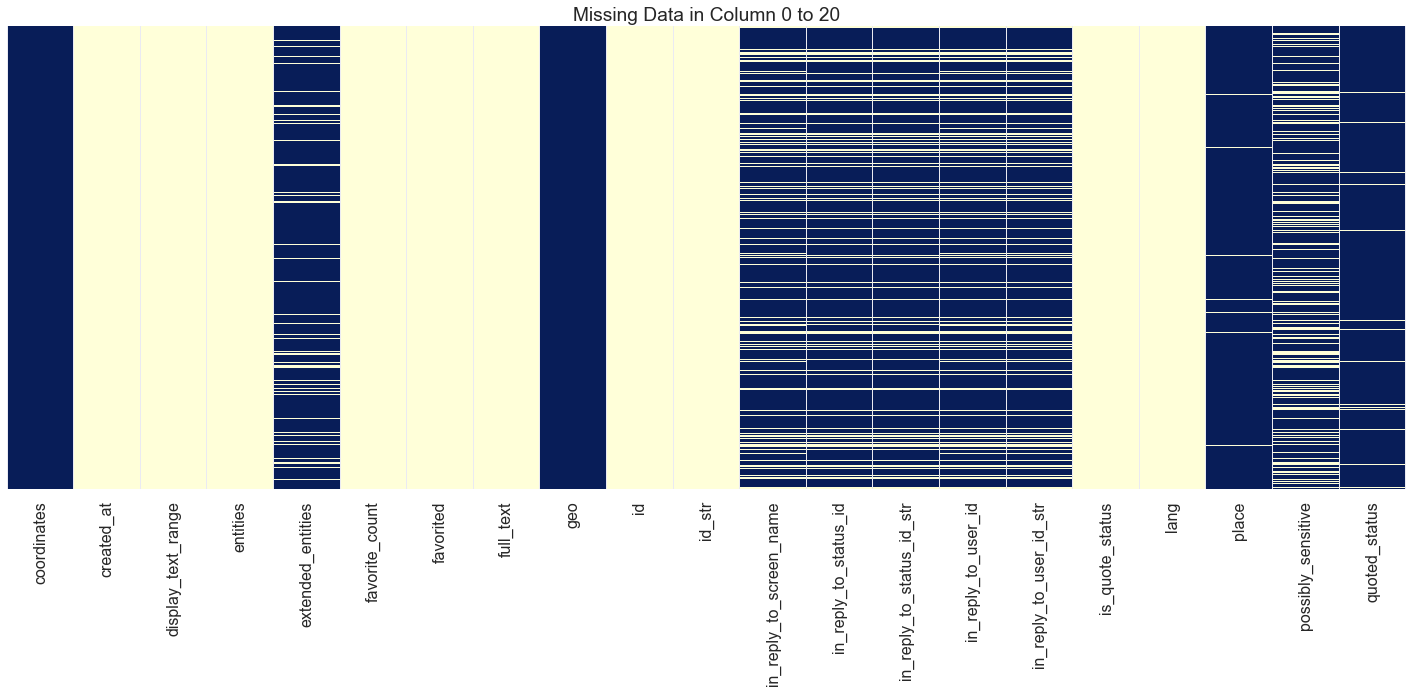

In [0]:
#plotting first null values
get_heatmap(tweets_df.ix[:,0:21], imgName='NaN_heatmap_col0_20.png')

In [0]:
# drop empty columns again (after exploding 'user' and 'entities')
threshold = len(tweets_df.columns.values)*0.5
tweets_df = tweets_df.dropna(thresh = threshold, axis='columns')

In [0]:
# take a look at the columns left
display(len(tweets_df.columns.values))
display(tweets_df.columns.values)

65

array(['coordinates', 'created_at', 'display_text_range', 'entities',
       'extended_entities', 'favorite_count', 'favorited', 'full_text',
       'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'is_quote_status', 'lang', 'place', 'possibly_sensitive',
       'quoted_status', 'quoted_status_id', 'quoted_status_id_str',
       'quoted_status_permalink', 'retweet_count', 'retweeted',
       'retweeted_status', 'source', 'truncated', 'user',
       'withheld_in_countries', 'user_created_at', 'user_default_profile',
       'user_default_profile_image', 'user_description', 'user_entities',
       'user_favourites_count', 'user_followers_count',
       'user_friends_count', 'user_geo_enabled',
       'user_has_extended_profile', 'user_id', 'user_id_str',
       'user_is_translation_enabled', 'user_lang', 'user_listed_count',
       'user_location', 'user_name', 'us

In [0]:
# we only interested in english tweets
tweets_df_en = tweets_df.loc[tweets_df['lang']=='en']
tweets_df_en.shape

(1042177, 65)

In [0]:
# duplicated / no longer userful columns
col_duplicate = ['entities','user', 'lang', 'user_lang', 'user_id', 'user_id_str', 'id_str']
# we dropped 'lang' as we only use english accounts for our dataset
# 'entities' and 'user' have already been parsed

# columns that we are obviously not interested
col_not_interested = ['user_entities']
# retweeted_status is the tweet object of the retweet - perhaps 

In [0]:
# drop duplicated columns and columns that we are not interested
tweets_df_en = tweets_df_en.drop(columns= (col_duplicate + col_not_interested))

In [0]:
# take a look at shape
tweets_df_en.shape

(1042177, 57)

In [0]:
# save as json
tweets_df_en.to_json('tweets_clean.json')

[Back to TOC](#TOC) <br/>
<a id ='Feature-Engineering'></a>
### 2.2 - Feature Engineering
Next, we want to aggregate tweet features to the accounts.

In [0]:
# read previous json file
tweets_df = pd.read_json('tweets_clean.json')

[Back to TOC](#TOC) <br/>
<a id ='FE-Tweet-Features'></a>
#### 2.2.1 - Feature Engineering - Tweet Features
We want to create the following features to prepare for NLP feature engineering / analysis: <br/>
1) text_rt: text of the retweet <br/>
2) text_tweet: text of the tweet (when there is no retweet) <br/>
3) encode tweet features <br/>

In [0]:
# although using tweet_mode='extended', we are still not getting the full text
# therefore, we tried to get full_text from retweeted_status
tweets_df['text_rt'] = tweets_df['retweeted_status'].map(lambda x: x['full_text'] if x and (not isinstance(x, float)) and ('full_text' in x) else None)
tweets_df['text_tweet'] = tweets_df['full_text'].where(tweets_df['text_rt'].map(lambda x: x is None), None)
tweets_df[['text_tweet', 'text_rt']].head(5)

,text_tweet,text_rt
0,NEW Coinpot Multiplier : How to Win more ( Bes...,None
1,How To Buy Things With Bitcoin Coinpot Litecoi...,None
10,Filling the Brita all the way to the top count...,None
100,You can collect other bitcoin faucets and incr...,None
1000,None,Michael Gove on 30 November 2018 and the truth...


In [0]:
# take a look at retweets
tweets_df[['text_tweet', 'text_rt']][tweets_df['text_rt'].map(lambda s: s is not None)].head()

,text_tweet,text_rt
1000,None,Michael Gove on 30 November 2018 and the truth...
10000,None,This is me being held by my Dad in 1955. I hav...
100002,None,Nicola Sturgeon uses the threat of a referendu...
100003,None,This horse was spotted walking around a Tesco ...
100004,None,When did worrying about immigration's impact o...


In [0]:
# encode tweet features

# 1 = favorited - True; 0 = favorited - False
tweets_df['favorited'] = tweets_df['favorited'].map(lambda x: 0 if x==False else 1) 

# 1 = retweeted-true; 0 = retweeted-false
tweets_df['retweeted'] = tweets_df['retweeted'].map(lambda x: 1 if x==True else 0) 

# 1 = tweet includes retweet; 0 = tweet does not include retweet
tweets_df['retweeted_status'] = tweets_df['retweeted_status'].map(lambda x: 0 if x==None else 1)

# 0 = none or information not available
tweets_df['user_listed_count'] = tweets_df['user_listed_count'].map(lambda x: x if x>0 else 0)

# replace nan with 0 for the following features (as for these features, missing values usually means 0)
for f in ['user_favourites_count', 'user_followers_count', 'user_friends_count']:
    tweets_df[f] = tweets_df[f].replace(np.nan, 0, regex=True)

In [0]:
tweets_df.shape

(1042177, 59)

[Back to TOC](#TOC) <br/>
<a id ='FE-User-Features)'></a>
#### 2.2.2 - Feature Engineering - User Features
As we suspected bots tweet more frequently / have different tweeting pattern from real users, we want to engineer the following features in order to examine them in the model: <br/>

1.   length of user description <br/>
2.   tweet frequencies (the mean, std, min, and max time between tweets for each account) <br/>
3.  account age (seconds from the account creation time to the latest tweet time) <br/>

In [0]:
# extract
tweets_df['screen_name'] = tweets_df['user_screen_name']

In [0]:
# account feature engineering
# create an intermedium df with all account-related data from tweets

users_description_len_df = tweets_df.drop_duplicates(subset=['screen_name'])
users_description_len_df['user_description_len'] = users_description_len_df['user_description'].map(lambda x: len(x) if x!=None else 0)

In [0]:
# account feature engineering
# get tweets interval stats (in seconds)

def create_tweet_time_stats(created_at_series):
    times = created_at_series['created_at'].sort_values().diff().dt.total_seconds()[1:]
    cols = ['tweet_time_mean', 'tweet_time_std', 'tweet_time_min', 'tweet_time_max']
    return pd.Series([times.mean(), times.std(), times.min(), times.max()], index=cols)

tweet_time_stats_df = tweets_df[['screen_name', 'created_at']].groupby('screen_name').apply(create_tweet_time_stats).reset_index()
tweet_time_stats_df.head()

,screen_name,tweet_time_mean,tweet_time_std,tweet_time_min,tweet_time_max
0,0604Arb1320,1103.088481,11493.389030,0.0,170593.0
1,07_smith,98062.614973,153488.369492,6.0,975586.0
2,0AngelHeart,1354.688172,5038.485992,6.0,34269.0
3,0ttaM,14095.382653,29149.325281,3.0,134152.0
4,100Climbs,2862.817204,6481.823049,6.0,40810.0


In [0]:
# account feature engineering
# get account age (in seconds)

reference_date = tweets_df['created_at'].max()
user_account_age_df = tweets_df[['screen_name', 'user_created_at']].groupby('screen_name').min().reset_index()
user_account_age_df['account_age'] = user_account_age_df['user_created_at'].map(lambda d: (reference_date - pd.to_datetime(d)).total_seconds())
del user_account_age_df['user_created_at']
user_account_age_df.head()

,screen_name,account_age
0,0604Arb1320,190794240.0
1,07_smith,222929527.0
2,0AngelHeart,238521195.0
3,0ttaM,142325785.0
4,100Climbs,279804439.0


In [0]:
# account feature engineering
# create a new dataframe with engineered features that are associated with each user
users_df = pd.DataFrame(tweets_df['screen_name']).drop_duplicates(subset='screen_name')
users_df = pd.merge(users_df, tweet_time_stats_df, left_on='screen_name', right_on='screen_name')
users_df = pd.merge(users_df, users_description_len_df[['screen_name', 'user_description_len']], left_on='screen_name', right_on='screen_name')
users_df = pd.merge(users_df, user_account_age_df, left_on='screen_name', right_on='screen_name')
users_df.head(5)

,screen_name,tweet_time_mean,tweet_time_std,tweet_time_min,tweet_time_max,user_description_len,account_age
0,ICVeo,1033.132275,1.937518e+03,0.0,8375.0,77,226104810.0
1,ianw2000uk,254.486146,1.616182e+03,0.0,26368.0,106,307106781.0
2,hmsglasgow,107.966921,1.068803e+03,0.0,16601.0,125,162646536.0
3,MarkHW1,607784.043011,2.526945e+06,3.0,28007804.0,0,281164185.0
4,RabHutchison,1122.005291,3.159343e+03,4.0,21281.0,119,261633864.0


In [0]:
# read the dataset with botometer score
boto_df = pd.read_json('immigration_brexit_bitcoin_full_boto.json')
boto_df['screen_name'] = boto_df['user'].map(lambda u: u['screen_name'])

In [0]:
# add botometer back
boto_class_df = boto_df[['class_boto','screen_name']].drop_duplicates(subset='screen_name')
tweets_df = pd.merge(tweets_df, boto_class_df, left_on='screen_name', right_on='screen_name')
tweets_df.columns.values

array(['coordinates', 'created_at', 'display_text_range',
       'extended_entities', 'favorite_count', 'favorited', 'full_text',
       'geo', 'id', 'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'is_quote_status', 'place',
       'possibly_sensitive', 'quoted_status', 'quoted_status_id',
       'quoted_status_id_str', 'quoted_status_permalink', 'retweet_count',
       'retweeted', 'retweeted_status', 'source', 'truncated',
       'withheld_in_countries', 'user_created_at', 'user_default_profile',
       'user_default_profile_image', 'user_description',
       'user_favourites_count', 'user_followers_count',
       'user_friends_count', 'user_geo_enabled',
       'user_has_extended_profile', 'user_is_translation_enabled',
       'user_listed_count', 'user_location', 'user_name',
       'user_profile_background_color',
       'user_profile_background_image_url',
       'user_profile_backgr

In [0]:
# merge the account information back to the dataset
tweets_df = pd.merge(tweets_df, users_df, left_on='screen_name', right_on='screen_name')
tweets_df.columns.values

array(['coordinates', 'created_at', 'display_text_range',
       'extended_entities', 'favorite_count', 'favorited', 'full_text',
       'geo', 'id', 'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'is_quote_status', 'place',
       'possibly_sensitive', 'quoted_status', 'quoted_status_id',
       'quoted_status_id_str', 'quoted_status_permalink', 'retweet_count',
       'retweeted', 'retweeted_status', 'source', 'truncated',
       'withheld_in_countries', 'user_created_at', 'user_default_profile',
       'user_default_profile_image', 'user_description',
       'user_favourites_count', 'user_followers_count',
       'user_friends_count', 'user_geo_enabled',
       'user_has_extended_profile', 'user_is_translation_enabled',
       'user_listed_count', 'user_location', 'user_name',
       'user_profile_background_color',
       'user_profile_background_image_url',
       'user_profile_backgr

[Back to TOC](#TOC) <br/>
<a id ='FE-Finalize-Clean'></a>
#### 2.2.3 - Feature Engineering - Finalize and Clean Up Data
We want to cealnup the data by dropping the columns that are no longer interesting / useful. For isntance, features such as 'created_at' has already been captured in account_age, 'user_orofile_sidebar_fill_color' might be interesting to see if that correlates with user types but we chose not to proceed in this project.

In [0]:
# delete columns that no longer useful
col_del = ['display_text_range', 'in_reply_to_status_id_str', 'in_reply_to_user_id_str','in_reply_to_status_id', 
           'in_reply_to_user_id', 'is_quote_status', 'quoted_status', 'quoted_status_id', 'quoted_status_id_str',
          'quoted_status_permalink', 'user_url', 'user_translator_type', 'user_default_profile_image',
          'user_default_profile', 'user_geo_enabled', 'user_has_extended_profile', 'user_profile_background_tile',
          'user_profile_image_url', 'user_profile_image_url_https', 'full_text', 'created_at', 
          'user_created_at', 'user_profile_background_image_url', 'user_profile_background_image_url_https',
          'user_profile_banner_url', 'user_profile_link_color', 'user_profile_sidebar_border_color',
           'possibly_sensitive', 'user_profile_sidebar_fill_color', 'user_profile_text_color', 'user_screen_name',
          'user_profile_background_color', 'extended_entities', 'in_reply_to_screen_name', 'truncated', 'user_location',
          'user_name', 'source', 'geo', 'place', 'withheld_in_countries', 'coordinates', 'user_is_translation_enabled', 
           'user_profile_use_background_image']

tweets_df = tweets_df.drop(columns=col_del, axis=1)

In [0]:
tweets_df.dtypes

favorite_count             int64
favorited                  int64
id                         int64
retweet_count              int64
retweeted                  int64
retweeted_status           int64
user_description          object
user_favourites_count    float64
user_followers_count     float64
user_friends_count       float64
user_listed_count        float64
user_statuses_count        int64
user_verified            float64
text_rt                   object
text_tweet                object
screen_name               object
class_boto                 int64
tweet_time_mean          float64
tweet_time_std           float64
tweet_time_min           float64
tweet_time_max           float64
user_description_len       int64
account_age              float64
dtype: object

In [0]:
# check user_verified
display(tweets_df.shape)
display(tweets_df[tweets_df['user_verified'].isnull()].shape)

(1042177, 23)

(1030080, 23)

In [0]:
# as it is mostly None, we decided to delete this column
del tweets_df['user_verified']

In [0]:
display(tweets_df.columns.values)
display(tweets_df.shape)

array(['favorite_count', 'favorited', 'id', 'retweet_count', 'retweeted',
       'retweeted_status', 'user_description', 'user_favourites_count',
       'user_followers_count', 'user_friends_count', 'user_listed_count',
       'user_statuses_count', 'text_rt', 'text_tweet', 'screen_name',
       'class_boto', 'tweet_time_mean', 'tweet_time_std',
       'tweet_time_min', 'tweet_time_max', 'user_description_len',
       'account_age'], dtype=object)

(1042177, 22)

In [0]:
tweets_df.describe()

,favorite_count,favorited,id,retweet_count,retweeted,retweeted_status,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_statuses_count,class_boto,tweet_time_mean,tweet_time_std,tweet_time_min,tweet_time_max,user_description_len,account_age
count,1.042177e+06,1042177.0,1.042177e+06,1.042177e+06,1042177.0,1.042177e+06,1.042177e+06,1.042177e+06,1.042177e+06,1.042177e+06,1.042177e+06,1.042177e+06,1.042151e+06,1.042095e+06,1.042151e+06,1.042151e+06,1.042177e+06,1.042177e+06
mean,1.369078e+00,0.0,1.065372e+18,1.161262e+03,0.0,6.618329e-01,2.911783e+04,4.698448e+03,2.436023e+03,8.248872e+01,5.079386e+04,8.472553e-02,2.421042e+04,7.999967e+04,3.607009e+02,7.625696e+05,8.635588e+01,1.653274e+08
std,4.821426e+01,0.0,3.293977e+16,1.102336e+04,0.0,4.730860e-01,5.792263e+04,5.551828e+04,9.868033e+03,5.149238e+02,1.228428e+05,2.784730e-01,2.718796e+05,6.574782e+05,1.442215e+05,6.166656e+06,5.849945e+01,1.003235e+08
min,0.000000e+00,0.0,1.240361e+09,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,2.654061e+00,6.853259e-01,0.000000e+00,5.200000e+01,0.000000e+00,9.692800e+04
25%,0.000000e+00,0.0,1.069875e+18,0.000000e+00,0.0,0.000000e+00,1.848000e+03,2.200000e+02,2.950000e+02,2.000000e+00,4.622000e+03,0.000000e+00,2.883926e+02,1.956763e+03,0.000000e+00,2.945100e+04,3.000000e+01,7.026666e+07
50%,0.000000e+00,0.0,1.071769e+18,2.100000e+01,0.0,1.000000e+00,9.991000e+03,7.330000e+02,8.980000e+02,1.000000e+01,1.721700e+04,0.000000e+00,1.406402e+03,5.712884e+03,0.000000e+00,5.203200e+04,9.400000e+01,1.710798e+08
75%,0.000000e+00,0.0,1.072138e+18,3.770000e+02,0.0,1.000000e+00,3.237500e+04,2.391000e+03,2.525000e+03,4.800000e+01,5.069800e+04,0.000000e+00,6.532113e+03,1.650136e+04,5.000000e+00,1.326000e+05,1.440000e+02,2.520437e+08
max,1.890900e+04,0.0,1.072320e+18,3.560981e+06,0.0,1.000000e+00,8.722570e+05,2.613669e+06,5.109480e+05,2.262400e+04,9.436490e+06,1.000000e+00,1.027626e+08,6.100153e+07,1.027626e+08,2.203665e+08,1.740000e+02,3.793244e+08


In [0]:
# create list of columns names for different categories and see if we have missed anything
col_response = ['class_boto']
col_pred_text = list(tweets_df.select_dtypes(['object']).columns.values)
col_id = ['id']
col_pred_numerical = list(tweets_df.select_dtypes(['float64', 'int64']).drop(columns=['class_boto', 'id']).columns.values)

In [0]:
# take a look at numerical features
display(col_pred_numerical)

['favorite_count',
 'favorited',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'user_favourites_count',
 'user_followers_count',
 'user_friends_count',
 'user_listed_count',
 'user_statuses_count',
 'tweet_time_mean',
 'tweet_time_std',
 'tweet_time_min',
 'tweet_time_max',
 'user_description_len',
 'account_age']

In [0]:
# take a look at text features
display(col_pred_text)

['user_description', 'text_rt', 'text_tweet', 'screen_name']

In [0]:
# delete numerical columns that have mean or std equals 0 (which implies same values for the columns)
col_name_del = []
for col in col_pred_numerical:
    if tweets_df[col].mean() == 0 or tweets_df[col].std() == 0:
        del tweets_df[col]
        col_name_del.append(col)
        col_pred_numerical.remove(col)
display(tweets_df.shape)
print ('{} are deleted as they only have one values across all the rows.'.format(str(col_name_del)))

(1042177, 20)

['favorited', 'retweeted'] are deleted as they only have one values across all the rows.


In [0]:
# before saving the file, we want to delete any rows with NaN values from the new columns
col_w_nan = tweets_df.columns[tweets_df.isna().any()].tolist()
col_w_nan

['user_description',
 'text_rt',
 'text_tweet',
 'tweet_time_mean',
 'tweet_time_std',
 'tweet_time_min',
 'tweet_time_max']

In [0]:
# while it is okay to have NaN in texts, we want to delete the rows with NaN Values in the tweet_time related columns
tweets_df = tweets_df.dropna(axis=0, subset=['tweet_time_mean', 'tweet_time_std', 'tweet_time_min', 'tweet_time_max'])
display(tweets_df.shape)
display(tweets_df.isna().any())

(1042095, 20)

favorite_count           False
id                       False
retweet_count            False
retweeted_status         False
user_description          True
user_favourites_count    False
user_followers_count     False
user_friends_count       False
user_listed_count        False
user_statuses_count      False
text_rt                   True
text_tweet                True
screen_name              False
class_boto               False
tweet_time_mean          False
tweet_time_std           False
tweet_time_min           False
tweet_time_max           False
user_description_len     False
account_age              False
dtype: bool

In [0]:
# great! let's save as json
users_df.to_json('users.json')
tweets_df.to_json('tweets_clean_final.json')

[Back to TOC](#TOC) <br/>
<a id ='NLP-Features'></a>
### 2.3 - Advanced Feature Engineering - NLP Features

After cleaning up the file and did some feature engineering, we tried to create some NLP features that might be interesting to our project, such as the length of tweets, the average word length an account use in the tweets.

In [0]:
# read the data
tweets_df = pd.read_json('tweets_clean_final.json')
users_df = pd.read_json('users.json')

In [0]:
col_nlp_text = ['tweet_len_mean', 'tweet_len_std', 'tweet_word_mean', 'tweet_word_std',
                'retweet_len_mean', 'retweet_len_std', 'retweet_word_mean', 'retweet_word_std']

with open('col_nlp_text.txt', 'w') as fp:
        ls_str = ",".join(col_nlp_text)
        fp.write(ls_str)

In [0]:
# function to get tweet length
def get_tweet_lens(tweet_series):
    return tweet_series.dropna().map(lambda s: len(s))

In [0]:
# function to get length of each word. filtering out hashtags, @, and links
def get_tweet_word_lens(tweet_series):
    tweets = tweet_series.dropna().values.tolist()
    words = [w for s in [t.split() for t in tweets] for w in s]
    filtered_words = filter(lambda w: not (w.startswith('@') or w.startswith('#') or w.startswith('http')), words)
    word_len = np.array([len(w) for w in filtered_words])
    return word_len

In [0]:
# function to create feature
def tweet_text_features(df):
    cols = col_nlp_text
    tweet_lens = get_tweet_lens(df['text_tweet'])
    tweet_word_lens = get_tweet_word_lens(df['text_tweet'])
    retweet_lens = get_tweet_lens(df['text_rt'])
    retweet_word_lens = get_tweet_word_lens(df['text_rt'])
    
    return pd.Series((tweet_lens.mean(), tweet_lens.std(), 
                    tweet_word_lens.mean(), tweet_word_lens.std(),
                    retweet_lens.mean(), retweet_lens.std(), 
                    retweet_word_lens.mean(), retweet_word_lens.std()), index=cols)

In [0]:
# get text features
text_df = tweets_df.groupby("screen_name").apply(tweet_text_features).reset_index()

In [0]:
# merge text features with tweets_df
tweets_df = pd.merge(tweets_df, text_df, left_on='screen_name', right_on='screen_name')

In [0]:
display(tweets_df.shape)
display(tweets_df.columns.values)

(1042095, 28)

array(['favorite_count', 'id', 'retweet_count', 'retweeted_status',
       'user_description', 'user_favourites_count',
       'user_followers_count', 'user_friends_count', 'user_listed_count',
       'user_statuses_count', 'text_rt', 'text_tweet', 'screen_name',
       'class_boto', 'tweet_time_mean', 'tweet_time_std',
       'tweet_time_min', 'tweet_time_max', 'user_description_len',
       'account_age', 'tweet_len_mean', 'tweet_len_std',
       'tweet_word_mean', 'tweet_word_std', 'retweet_len_mean',
       'retweet_len_std', 'retweet_word_mean', 'retweet_word_std'],
      dtype=object)

In [0]:
users_df.shape

(4226, 28)

In [0]:
# merge text features with uers_df
users_df = pd.merge(users_df, text_df, left_on='screen_name', right_on='screen_name')

In [0]:
# clean up users_df a bit and join boto scores
users_df = pd.merge(users_df, tweets_df[['class_boto', 'screen_name']], left_on='screen_name', right_on='screen_name')
users_df = users_df.drop_duplicates(subset='screen_name')

In [0]:
# great! let's save as json-again
users_df.to_json('users_final.json')
tweets_df.to_json('tweets_clean_final2.json')

[Back to TOC](#TOC) <br/>
<a id ='Important-Features'></a>
### 2.4 - Important Features

Before we conclude our data processing, we want to explore if there are any tweets features that we haven't captured but might be interesting for our analysis. <br/>

We also want to explore the relationship among account-level features we have selected / engineered, and see if any of them are particularly interesting in identifying bots / nonbots.

In [0]:
# read the data
tweets_df = pd.read_json('tweets_clean_final2.json')

In [0]:
# separte bots and non-bots tweets for easy plotting
tweets_0 = tweets_df.loc[tweets_df['class_boto']==0]
tweets_1 = tweets_df.loc[tweets_df['class_boto']==1]

In [0]:
# read the user dataframe
users_df = pd.read_json('users_final.json')

In [0]:
# separte bots and non-bots accounts for easy plotting
users_0 = users_df.loc[users_df['class_boto']==0]
users_1 = users_df.loc[users_df['class_boto']==1]

Let's examine the data. We removed "screen_name" from showing in the dataframe for privacy.

In [0]:
# examine the tweets data
# we drop screen_name for privacy
tweets_df.drop(columns=['screen_name']).head(5)

,favorite_count,id,retweet_count,retweeted_status,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_statuses_count,text_rt,text_tweet,class_boto,tweet_time_mean,tweet_time_std,tweet_time_min,tweet_time_max,user_description_len,account_age,tweet_len_mean,tweet_len_std,tweet_word_mean,tweet_word_std,retweet_len_mean,retweet_len_std,retweet_word_mean,retweet_word_std
0,0,1072242970626326532,0,0,"Tweet to LOVE, not to HATE! Simply sharing the...",423,118672,108291,347,1206739,None,NEW Coinpot Multiplier : How to Win more ( Bes...,1,1033.132275,1937.518271,0.0,8375.0,77,226104810,77.521053,24.772127,4.643869,2.396604,NaN,NaN,NaN,NaN
1,0,1072242968810131457,0,0,"Tweet to LOVE, not to HATE! Simply sharing the...",423,118672,108291,347,1206739,None,How To Buy Things With Bitcoin Coinpot Litecoi...,1,1033.132275,1937.518271,0.0,8375.0,77,226104810,77.521053,24.772127,4.643869,2.396604,NaN,NaN,NaN,NaN
2,0,1071853531710324736,0,0,"Tweet to LOVE, not to HATE! Simply sharing the...",423,118672,108291,347,1206739,None,they need to pull up the stats for canada. mtl...,1,1033.132275,1937.518271,0.0,8375.0,77,226104810,77.521053,24.772127,4.643869,2.396604,NaN,NaN,NaN,NaN
3,0,1071462035878236165,0,0,"Tweet to LOVE, not to HATE! Simply sharing the...",423,118672,108291,347,1206739,None,Complete List Of High Paying CoinPot Faucets!!...,1,1033.132275,1937.518271,0.0,8375.0,77,226104810,77.521053,24.772127,4.643869,2.396604,NaN,NaN,NaN,NaN
4,0,1071462034150174727,0,0,"Tweet to LOVE, not to HATE! Simply sharing the...",423,118672,108291,347,1206739,None,Easy To Mine Cryptocurrency For Free With Coin...,1,1033.132275,1937.518271,0.0,8375.0,77,226104810,77.521053,24.772127,4.643869,2.396604,NaN,NaN,NaN,NaN


In [0]:
# examine the users data
# we drop screen_name for privacy
users_df.drop(columns=['screen_name']).head(5)

,favorite_count,id,retweet_count,retweeted_status,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_statuses_count,text_rt,text_tweet,class_boto,tweet_time_mean,tweet_time_std,tweet_time_min,tweet_time_max,user_description_len,account_age,tweet_len_mean,tweet_len_std,tweet_word_mean,tweet_word_std,retweet_len_mean,retweet_len_std,retweet_word_mean,retweet_word_std
0,0,1072242970626326532,0,0,"Tweet to LOVE, not to HATE! Simply sharing the...",423,118672,108291,347,1206739,None,NEW Coinpot Multiplier : How to Win more ( Bes...,1,1033.132275,1937.518271,0.0,8375.0,77,226104810,77.521053,24.772127,4.643869,2.396604,NaN,NaN,NaN,NaN
1000085,0,1072250182291648512,0,0,"Lifelong SWFC fan, seen the good & bad that go...",5506,926,681,17,41788,None,A first class twat in a house full of twats ht...,0,4018.582418,8728.931176,23.0,62991.0,151,239371072,93.357798,65.840228,4.578806,2.532881,179.567568,77.685718,4.750636,2.588270
1000268,1,1072182528595779585,0,0,Britain's best-selling newspaper.,42295,290,781,9,23383,None,Ester McVey is a plant. The intention is to tu...,0,7585.967742,13519.947798,20.0,70114.0,33,250070652,106.466102,50.406329,4.712589,2.663969,124.507246,81.939114,4.602871,2.476078
1000455,0,1072250902470422528,0,0,Paddling my own canoe.,6803,910,1526,35,32557,None,The Labour Party has now secured a debate tomo...,0,6737.979592,11865.972558,22.0,68340.0,22,297961902,115.226950,55.895613,4.874718,2.605085,198.857143,66.421454,4.703540,2.445094
1000603,0,1071920364790448128,97,1,A sovereign state is \nneither depend...,2511,265,864,1,4194,"Mundell claims without any challenge, that a ‘...",None,0,32291.938776,107215.429475,12.0,866117.0,123,84557237,98.750000,66.868207,4.303571,2.162337,209.857143,74.814136,4.812866,2.629586


In [0]:
# scatter plot
def scatterplot (col_b1, col_b2, col_r1, col_r2, col1, col2):
    plt.scatter(col_b1, col_b2, s=5, color='salmon', label='bot', alpha=0.75)
    plt.scatter(col_r1, col_r2, s=5, color='royalblue', label='non-bot', alpha=0.75)
    plt.xlabel(str(col1))
    plt.ylabel(str(col2))
    #plt.xlim(xlimit)
    #plt.ylim(ylimit)
    plt.legend(loc='best', bbox_to_anchor=(0.85, 0., 0.5, 0.5))
    title = str(col1) + ' vs ' + str(col2)
    plt.title(title)
    plt.savefig(str(title)+'.png')

In [0]:
# scatter plot2
def scatterplot2 (col_b1, col_b2, col_r1, col_r2, col1, col2):
    plt.scatter(col_b1, col_b2, s=3, color='salmon', label='bot', alpha=0.0025)
    plt.scatter(col_r1, col_r2, s=3, color='royalblue', label='non-bot', alpha=0.0025)
    plt.xlabel(str(col1))
    plt.ylabel(str(col2))
    #plt.xlim(xlimit)
    #plt.ylim(ylimit)
    plt.legend(loc='best', bbox_to_anchor=(0.85, 0., 0.5, 0.5))
    title = str(col1) + ' vs ' + str(col2)
    plt.title(title)
    plt.savefig(str(title)+'.png')

In [0]:
# histogram
def hist_plot(col, xlabel, ylabel, title):
    #values = col.values[~np.isnan(col.values)]
    plt.hist(col)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.xlim(xlimit)
    plt.title(title)
    plt.savefig(str(title)+'.png')
    return None

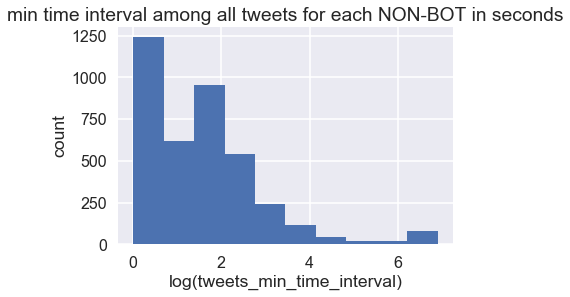

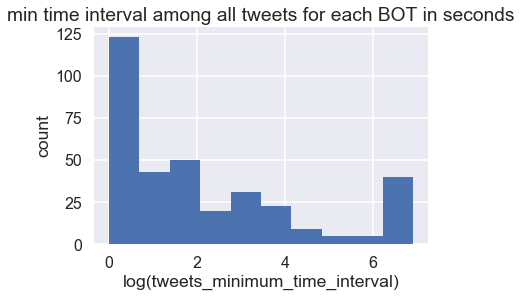

In [0]:
# quick plots
plt.figure(figsize=(6,4))
hist_plot(np.log(users_0['tweet_time_min'].values.clip(1, 1000)), 'log(tweets_min_time_interval)','count', 'min time interval among all tweets for each NON-BOT in seconds')
plt.figure(figsize=(6,4))
hist_plot(np.log(users_1['tweet_time_min'].values.clip(1, 1000)), 'log(tweets_minimum_time_interval)','count', 'min time interval among all tweets for each BOT in seconds')

It looks like both botometer-defined non-bot (botometer score < 0.2) and bots (botometer score >=0.2) are heavily screwed towards almost 0 seconds for minimum time interval between tweets of each users. Bots tend to have even more screwed minimum time interval towards 0. <br/>

The botometer-identified bots also have heavily screwed minimim tweet time interval but many of them have significantly larger minimum time interval. We think it is reasonable as the bots might be set up to only tweet at a certain interval.

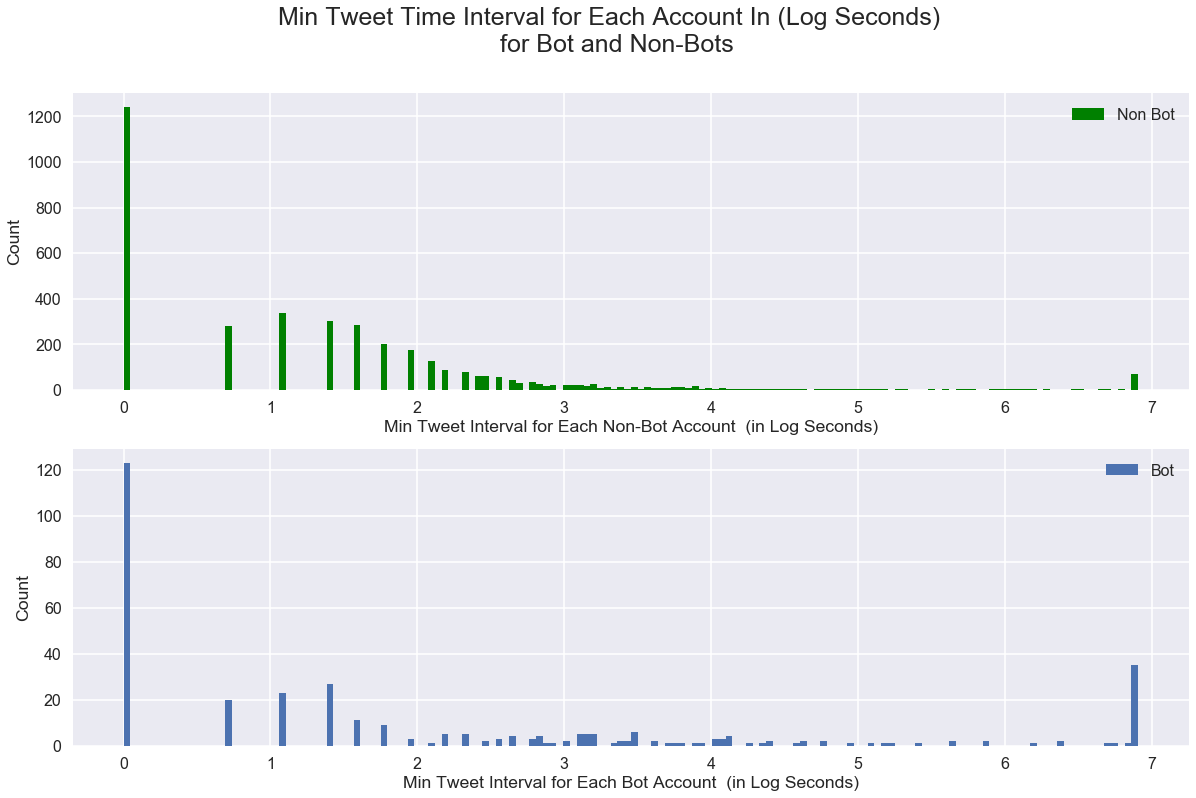

In [0]:
fig, ax = plt.subplots(2,1, figsize=(20,12))
fig.suptitle("Min Tweet Time Interval for Each Account In (Log Seconds) \n for Bot and Non-Bots", fontsize=25)

bot_data = np.log(users_0['tweet_time_min'].values.clip(1, 1000))
non_bot_data = np.log(users_1['tweet_time_min'].values.clip(1, 1000))

ax[0].hist(bot_data, bins=150, label='Non Bot', color="g")
ax[1].hist(non_bot_data, bins=150, label='Bot')

ax[0].set_xlabel('Min Tweet Interval for Each Non-Bot Account  (in Log Seconds)')
ax[0].set_ylabel('Count')
ax[1].set_xlabel('Min Tweet Interval for Each Bot Account  (in Log Seconds)')
ax[1].set_ylabel('Count')

ax[0].legend()
ax[1].legend();

From the plot above, it seems like bots tend to have more large min tweets interval time. One explanation could be that some bots pre-set a time to tweets.

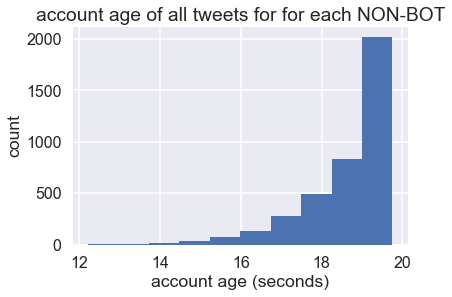

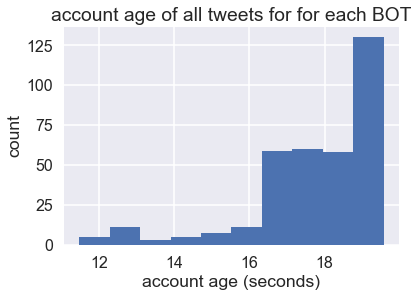

In [0]:
# quick plots
plt.figure(figsize=(6,4))
hist_plot(np.log(users_0['account_age'].values.clip(0,1000000000)), 'account age (seconds)','count', 'account age of all tweets for for each NON-BOT')
plt.figure(figsize=(6,4))
hist_plot(np.log(users_1['account_age'].values.clip(0,1000000000)), 'account age (seconds)','count', 'account age of all tweets for for each BOT')

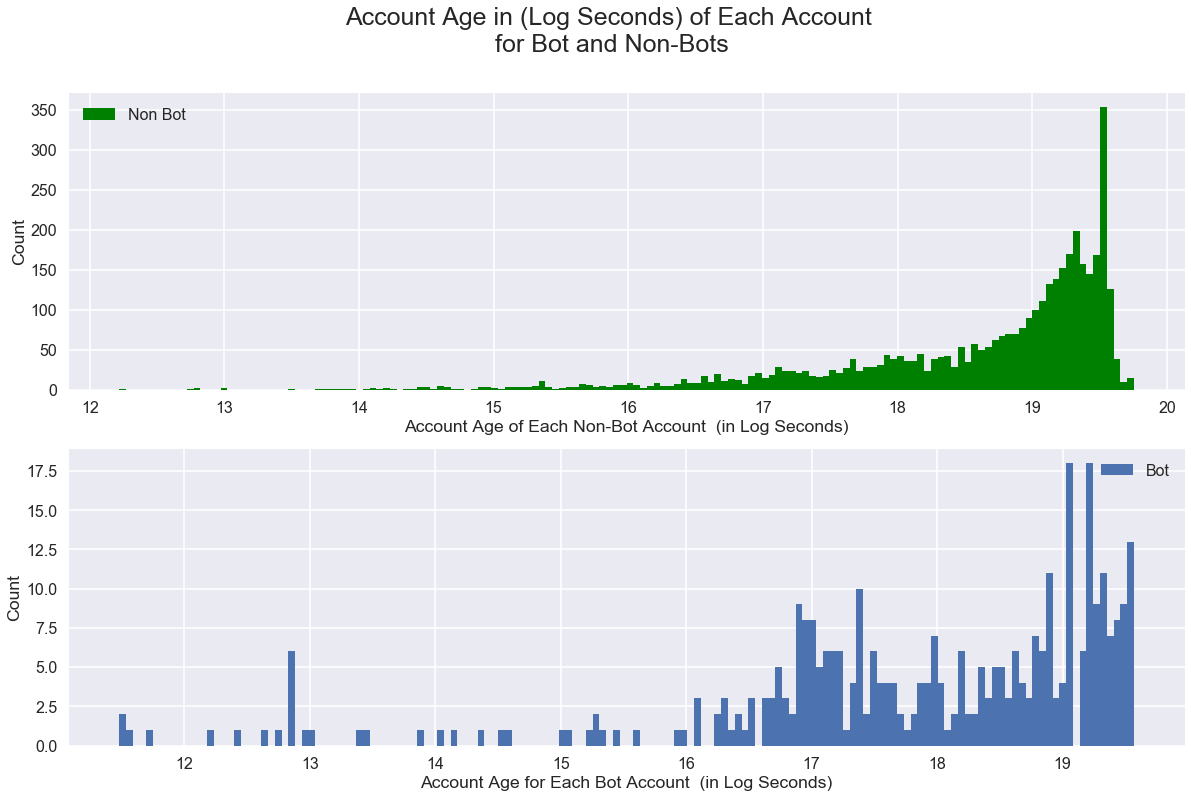

In [0]:
fig, ax = plt.subplots(2,1, figsize=(20,12))
fig.suptitle("Account Age in (Log Seconds) of Each Account\n for Bot and Non-Bots", fontsize=25)

bot_data = np.log(users_0['account_age'].values.clip(0,1000000000))
non_bot_data =np.log(users_1['account_age'].values.clip(0,1000000000))

ax[0].hist(bot_data, bins=150, label='Non Bot', color="g")
ax[1].hist(non_bot_data, bins=150, label='Bot')

ax[0].set_xlabel('Account Age of Each Non-Bot Account  (in Log Seconds)')
ax[0].set_ylabel('Count')
ax[1].set_xlabel('Account Age for Each Bot Account  (in Log Seconds)')
ax[1].set_ylabel('Count')

ax[0].legend()
ax[1].legend();

While the account age for non-bot accounts looks continuous, the account_age for bots seemed to be more fragmented - one reason could be waves of hot topics / events.

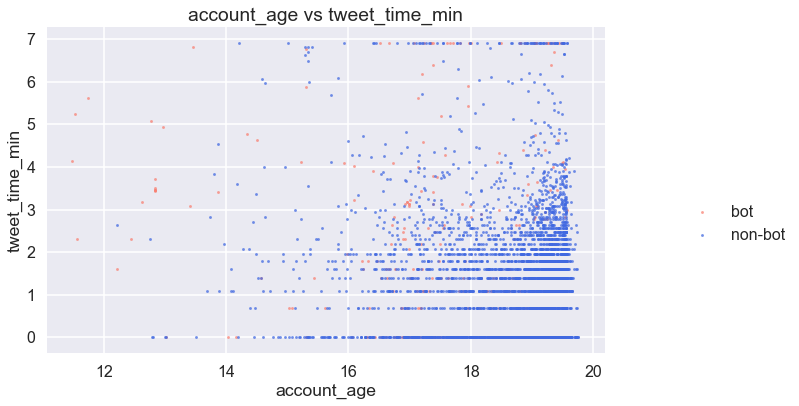

In [0]:
# quick plots
plt.figure(figsize=(10,6))
scatterplot(np.log(users_1['account_age'].values.clip(0,1000000000)), np.log(users_1['tweet_time_min'].values.clip(1, 1000)),
          np.log(users_0['account_age'].values.clip(0,1000000000)), np.log(users_0['tweet_time_min'].values.clip(1, 1000)),
           'account_age', 'tweet_time_min')

Given the tweets are the most recent 200 tweets from each account, it looks like the user with older accounts have long minimum time inbetweem two tweets, while bots' minimum time inbetween tweets spread across regardless of account_age.

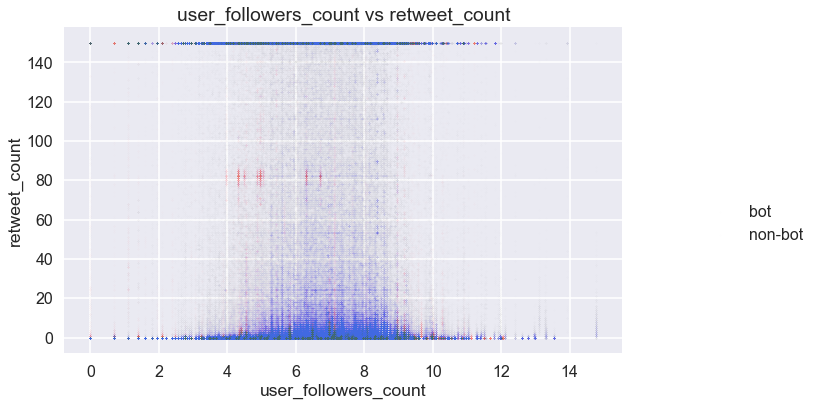

In [0]:
# quick plots
plt.figure(figsize=(10,6))
scatterplot2(np.log(tweets_1['user_followers_count'].values.clip(0,1000000000)), tweets_1['retweet_count'].values.clip(0,150),
          np.log(tweets_0['user_followers_count'].values.clip(0,1000000000)), tweets_0['retweet_count'].values.clip(0,150),
           'user_followers_count', 'retweet_count')

Although the word count of the retweeted post for each tweet has an interesting pattern at around 80 word counts (has most bots), we decided not to include as the rest of the bots are very well blended with non-bots regarding retweet count, and the clusters we've observed above, given the rest of the plot, might be outliers or special events.

[Back to TOC](#TOC) <br/>
<a id ='Relations-in-Data'></a>
### 2.5 - Relations in Data
Last step before wrapping up the preprocessing, we want to explore the correlation among the different features.

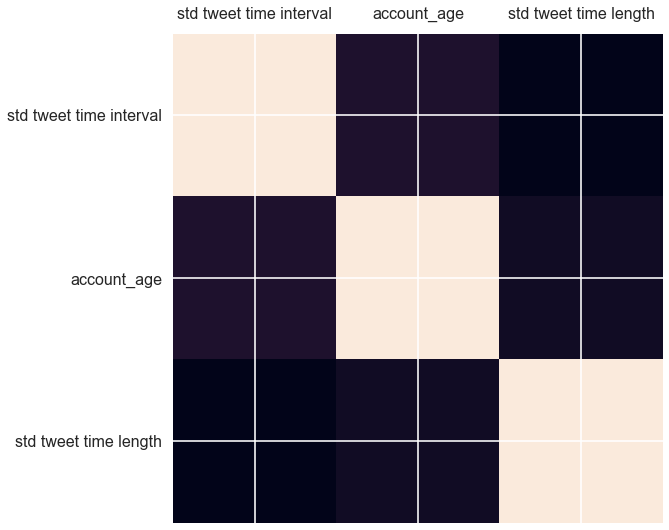

In [0]:
# correlation matrix
# quick look at some features we might be interested in

fig, ax = plt.subplots( figsize=(18,9))

col_corr = ['tweet_time_std', 'account_age', 'tweet_len_std']
labels_corr = ['std tweet time interval', 'account_age', 'std tweet time length']
ax.matshow(users_df[col_corr].corr())
ax.set_xticklabels([''] + labels_corr)
ax.set_yticklabels([''] + labels_corr);

In [0]:
# correlation matrix 
pd.DataFrame(users_df[col_corr].corr())

,tweet_time_std,account_age,tweet_len_std
tweet_time_std,1.000000,0.036602,-0.047074
account_age,0.036602,1.000000,-0.001269
tweet_len_std,-0.047074,-0.001269,1.000000


To our surprise, it seems like there is no strong correlation among these three features, which we thought would be correlated.

We also want to look at the common words / topics of each account among their most recent 200 tweets.

In [0]:
def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"|", "", string)
    string = re.sub(r"u\s", "", string)
    string = re.sub(r'[^\x00-\x7F]+',' ', string)
    return string.strip().lower()

In [0]:
def generate_wordCloud(text, title):
    stopwords = set(STOPWORDS)
    extra_stopwords = {'one', 'al','et', 'br', 'Po', 'th', 'sayi', 'fr','wi', 'Unknown','co',
                       'https', 'u\'rt', 'nhttp','text', 'rt', "amp", "nhttps",'u','n\'t'}
    stopwords = stopwords.union(extra_stopwords)
    wc = WordCloud(stopwords=stopwords,
                  max_font_size=100,
                  max_words=100,
                  random_state=30,
                  background_color='white',mask=None).generate(str(text))

    plt.figure(figsize=(15,20))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off') # dont show the axes
    plt.title(title, fontdict={'size': 35,'color':"red" ,
                                  'verticalalignment': 'bottom'})
    plt.show()

In [0]:
bot_tweets_str = ""
nonbot_tweets_str = ""

df1 = tweets_1[['text_tweet']]
df0 = tweets_0[['text_tweet']]


df1.fillna(value=pd.np.nan, inplace=True) #Make all NA variable as NAN
df0.fillna(value=pd.np.nan, inplace=True) #Make all NA variable as NAN

dataset_1=df1[df1.text_tweet.notnull()] #get not NULL data into dataset_
dataset_0=df0[df0.text_tweet.notnull()]

In [0]:
# take a look at the first 10 tweets
display(dataset_0[0:10])

,text_tweet
200,@HistoryMeister @paulgilding Lascelles - there...
203,Almost more important that Brexit #england #br...
208,@Prof_Malhotra some local colour amidst this I...
209,Spot on as always @Prof_Malhotra ! It was alwa...
219,Dear @BBCNewsnight Please ask @EmilyMaitlisMVP...
220,#PRCAAwards Well done @VicNayLey New PR firm...
221,#PRCAAwards Well done @PembrokeAndRye New PR...
224,"@RBKC The residents of Blenheim Crescent, Port..."
228,@PoppyLegion I saw this in Petworth today - in...
229,They have strong views on these matters at the...


In [0]:
for tweet in  dataset_1.text_tweet[0:10]:
    bot_tweets_str = bot_tweets_str+ dataset_1.text_tweet.replace('NaN','')
    

for tweet in  dataset_0.text_tweet[0:10]:
    nonbot_tweets_str  = nonbot_tweets_str+ dataset_0.text_tweet.replace('NaN','')

In [0]:
# to download : conda install -c conda-forge wordcloud or pip install wordcloud
from wordcloud import WordCloud

generate_wordCloud(bot_tweets_str,'Bot')
generate_wordCloud(nonbot_tweets_str,'Non-Bot')

[Back to TOC](#TOC) <br/>
<a id ='Standardization'></a>
### 2.6 - Standardization and Discussion

Up to this point, it has become very obvious that the most interesting features in telling bots / non-bots apart are account-level features. Moreover, account-level engineered features are much better at telling bot / non-bots apart. <br/>

Moreover, from the plots in the previous sections, it became obvious that many of our data are not normally distributed. Standardization is necessary to make our model legit. <br/>


As the last step of the EDA and data preprocessing, we consolidated all our account-level data, remove the columns that no longer be useful in our analysis, the standardize the numerical features.

In [0]:
# read the data
users_df = pd.read_json('users_final.json')

In [0]:
users_df.columns.values

array(['favorite_count', 'id', 'retweet_count', 'retweeted_status',
       'user_description', 'user_favourites_count',
       'user_followers_count', 'user_friends_count', 'user_listed_count',
       'user_statuses_count', 'text_rt', 'text_tweet', 'screen_name',
       'class_boto', 'tweet_time_mean', 'tweet_time_std',
       'tweet_time_min', 'tweet_time_max', 'user_description_len',
       'account_age', 'tweet_len_mean', 'tweet_len_std',
       'tweet_word_mean', 'tweet_word_std', 'retweet_len_mean',
       'retweet_len_std', 'retweet_word_mean', 'retweet_word_std'],
      dtype=object)

In [0]:
# we want to check how many accounts have left after all the cleansing
users_df.shape

(4226, 28)

In [0]:
display(users_df.columns.values)
display(users_df.shape)

array(['favorite_count', 'id', 'retweet_count', 'retweeted_status',
       'user_description', 'user_favourites_count',
       'user_followers_count', 'user_friends_count', 'user_listed_count',
       'user_statuses_count', 'text_rt', 'text_tweet', 'screen_name',
       'class_boto', 'tweet_time_mean', 'tweet_time_std',
       'tweet_time_min', 'tweet_time_max', 'user_description_len',
       'account_age', 'tweet_len_mean', 'tweet_len_std',
       'tweet_word_mean', 'tweet_word_std', 'retweet_len_mean',
       'retweet_len_std', 'retweet_word_mean', 'retweet_word_std'],
      dtype=object)

(4226, 28)

We still have 28 columns, which include two reference columns ('id' and 'screen_name'), one predictor column ('class_boto'). 

In [0]:
users_df.dtypes

favorite_count             int64
id                         int64
retweet_count              int64
retweeted_status           int64
user_description          object
user_favourites_count      int64
user_followers_count       int64
user_friends_count         int64
user_listed_count          int64
user_statuses_count        int64
text_rt                   object
text_tweet                object
screen_name               object
class_boto                 int64
tweet_time_mean          float64
tweet_time_std           float64
tweet_time_min           float64
tweet_time_max           float64
user_description_len       int64
account_age                int64
tweet_len_mean           float64
tweet_len_std            float64
tweet_word_mean          float64
tweet_word_std           float64
retweet_len_mean         float64
retweet_len_std          float64
retweet_word_mean        float64
retweet_word_std         float64
dtype: object

In [0]:
# separate numerical columns and text columns again
col_response = ['class_boto']
col_pred_text = list(users_df.select_dtypes(['object']).drop(columns=['screen_name']).columns.values)
col_ref = ['id', 'screen_name']
col_pred_numerical = list(users_df.select_dtypes(['float64', 'int64']).drop(columns=['class_boto', 'id']).columns.values)

In [0]:
# save the column lists
c_list_names = ['col_pred_numerical', 'col_ref', 'col_response', 'col_pred_text']
c_list = [col_pred_numerical, col_ref, col_response, col_pred_text]
for c_name, c in zip(c_list_names, c_list):
    with open(c_name+'.txt', 'w') as fp:
        ls_str = ",".join(col_pred_numerical)
        fp.write(ls_str)

In [0]:
display(users_df.shape)
display(users_df.isna().any())

(4226, 28)

favorite_count           False
id                       False
retweet_count            False
retweeted_status         False
user_description          True
user_favourites_count    False
user_followers_count     False
user_friends_count       False
user_listed_count        False
user_statuses_count      False
text_rt                   True
text_tweet                True
screen_name              False
class_boto               False
tweet_time_mean          False
tweet_time_std           False
tweet_time_min           False
tweet_time_max           False
user_description_len     False
account_age              False
tweet_len_mean            True
tweet_len_std             True
tweet_word_mean           True
tweet_word_std            True
retweet_len_mean          True
retweet_len_std           True
retweet_word_mean         True
retweet_word_std          True
dtype: bool

In [0]:
# cleaning up NaN on numerical columns by assigning them 0
users_df[col_pred_numerical] = users_df[col_pred_numerical].fillna(0)

In [0]:
from sklearn import preprocessing

def standardize(df):
    scaler = preprocessing.StandardScaler()
    df = scaler.fit_transform(df)
    return df

In [0]:
# create a new copy with numercial columns standardized
users_df[col_pred_numerical] = standardize(users_df[col_pred_numerical])

In [0]:
# check if the copy 
display(users_df.describe())
display(users_df.shape)

,favorite_count,id,retweet_count,retweeted_status,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_statuses_count,class_boto,tweet_time_mean,tweet_time_std,tweet_time_min,tweet_time_max,user_description_len,account_age,tweet_len_mean,tweet_len_std,tweet_word_mean,tweet_word_std,retweet_len_mean,retweet_len_std,retweet_word_mean,retweet_word_std
count,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4226.000000,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03
mean,9.703943e-17,1.072062e+18,-5.133731e-17,1.249986e-16,-2.878015e-17,1.523732e-17,8.557860e-18,-1.315599e-16,-1.088287e-17,0.082584,1.884962e-18,-3.707530e-18,3.383901e-17,1.157249e-17,4.057332e-16,-1.116003e-16,-6.029252e-18,3.007533e-16,-4.242544e-16,3.718695e-16,1.810615e-16,1.399732e-16,-1.968242e-16,-3.429974e-16
std,1.000118e+00,3.518030e+15,1.000118e+00,1.000118e+00,1.000118e+00,1.000118e+00,1.000118e+00,1.000118e+00,1.000118e+00,0.275285,1.000118e+00,1.000118e+00,1.000118e+00,1.000118e+00,1.000118e+00,1.000118e+00,1.000118e+00,1.000118e+00,1.000118e+00,1.000118e+00,1.000118e+00,1.000118e+00,1.000118e+00,1.000118e+00
min,-1.017011e-01,8.705541e+17,-1.115030e-01,-1.265154e+00,-4.849644e-01,-9.288413e-02,-1.882989e-01,-1.647460e-01,-2.397743e-01,0.000000,-7.548576e-02,-1.240359e-01,-4.307066e-02,-1.539493e-01,-1.421002e+00,-1.647139e+00,-1.923047e+00,-1.686625e+00,-3.630790e+00,-2.858170e+00,-3.152194e+00,-2.844186e+00,-3.748898e+00,-3.458390e+00
25%,-1.017011e-01,1.072195e+18,-1.115030e-01,-1.265154e+00,-4.587417e-01,-8.961513e-02,-1.677584e-01,-1.625237e-01,-2.218025e-01,0.000000,-7.474640e-02,-1.219509e-01,-4.307066e-02,-1.501365e-01,-9.950487e-01,-9.701341e-01,-5.238541e-01,-6.050294e-01,-7.939639e-03,-1.203602e-01,-1.679538e-01,-3.083459e-02,1.481374e-01,8.063067e-02
50%,-1.017011e-01,1.072253e+18,-1.105211e-01,7.904174e-01,-3.381680e-01,-8.131076e-02,-1.281914e-01,-1.469681e-01,-1.717429e-01,0.000000,-7.284825e-02,-1.185913e-01,-4.297456e-02,-1.465433e-01,9.539089e-02,1.152168e-01,-8.393633e-02,1.221680e-01,1.751376e-01,1.072919e-01,2.923449e-01,1.986888e-01,2.297437e-01,1.910382e-01
75%,-1.017011e-01,1.072275e+18,-7.827123e-02,7.904174e-01,2.087058e-02,-5.314358e-02,-1.888093e-02,-8.030114e-02,-2.021151e-02,0.000000,-6.288424e-02,-1.066719e-01,-4.285444e-02,-1.328250e-01,9.984112e-01,8.490765e-01,4.698467e-01,5.891938e-01,3.523146e-01,3.257232e-01,5.515590e-01,3.881942e-01,3.274733e-01,2.954122e-01
max,3.378112e+01,1.072320e+18,4.637228e+01,7.904174e-01,1.793084e+01,5.192418e+01,4.162489e+01,5.010437e+01,5.402938e+01,1.000000,5.308569e+01,3.565216e+01,5.440004e+01,2.301665e+01,1.543631e+00,2.090942e+00,1.103629e+01,8.016903e+00,1.045978e+01,1.460471e+01,5.003616e+00,7.567214e+00,4.688847e+00,1.645674e+01


(4226, 28)

In [0]:
# save to json
users_df.to_json('users_final_std.json')